In [10]:
import numpy as np
from main import *
from utils import Utility
from Fair_Taxi_MDP_Penalty_V2 import Fair_Taxi_MDP_Penalty_V2


In [11]:
size = 10
loc_coords = [[0,0],[3,2]]
dest_coords = [[0,4],[3,3]]
fuel = 100

env = Fair_Taxi_MDP_Penalty_V2(
    size=size,
    loc_coords=loc_coords,
    dest_coords=dest_coords,
    fuel=fuel,
    output_path=None
)

In [15]:
# ---- Load dataset ----
dataset = np.load("./data/dataset_v3.npy", allow_pickle=True).item()

# ---- Preprocess timesteps ----
dataset = preprocess_timesteps(dataset)

# ---- Preprocess rewards ----
dataset, norm_stats = preprocess_rewards(dataset, method='linear')

# ---- Preprocess Raccs ----
dataset = preprocess_Raccs(dataset, horizon=fuel)

dataset = preprocess_states(dataset, env, one_hot_pass_idx=True, concat_raccs=True)

# ---- Preprocess scalarization ----
utility = Utility(kind='piecewise_log', weights=None, shift=0.0)
dataset = preprocess_scalarization(dataset, utility)

In [16]:
dataset

{'states': array([[ 9.        ,  9.        ,  0.        , ...,  1.        ,
          0.        ,  0.        ],
        [ 9.        ,  8.        ,  0.        , ...,  1.        ,
          0.        ,  0.        ],
        [ 9.        ,  7.        ,  0.        , ...,  1.        ,
          0.        ,  0.        ],
        ...,
        [ 3.        ,  2.        ,  1.        , ...,  0.        ,
         -0.33333334, 17.66666603],
        [ 3.        ,  3.        ,  1.        , ...,  0.        ,
         -0.33333334, 17.66666603],
        [ 3.        ,  3.        ,  0.        , ...,  1.        ,
         -0.33333334, 18.66666603]]),
 'actions': array([1, 1, 1, ..., 0, 5, 1], dtype=int32),
 'rewards': array([[0.        ],
        [0.        ],
        [0.        ],
        ...,
        [0.        ],
        [0.05505967],
        [0.        ]], dtype=float32),
 'next_states': array([[ 9.        ,  8.        ,  0.        , ...,  1.        ,
          0.        ,  0.        ],
        [ 9.    

In [19]:
for k, v in dataset.items():
    print(k, v.shape)

states (100000, 8)
actions (100000,)
rewards (100000, 1)
next_states (100000, 8)
dones (100000,)
timesteps (100000,)
Raccs (100000, 2)
initial_states (100000, 8)
next_timesteps (100000,)
next_Raccs (100000, 2)


In [20]:
def to_episode_arrays_fixed_horizon(dataset, horizon=100):
    num_steps = dataset['states'].shape[0]
    num_episodes = num_steps // horizon

    def reshape(arr, extra_dims=None):
        if extra_dims is None:
            arr = arr.reshape(num_episodes, horizon)
        else:
            arr = arr.reshape(num_episodes, horizon, *extra_dims)
        return arr

    out = {
        'states': reshape(dataset['states'], (dataset['states'].shape[1],)),        # (1000, 100, 8)
        'actions': reshape(dataset['actions']),                                    # (1000, 100)
        'rewards': reshape(dataset['rewards'], (1,)),                              # (1000, 100, 1)
        'next_states': reshape(dataset['next_states'], (dataset['next_states'].shape[1],)),  # (1000, 100, 8)
        'dones': reshape(dataset['dones']),                                        # (1000, 100)
        'timesteps': reshape(dataset['timesteps']),                                # (1000, 100)
        'Raccs': reshape(dataset['Raccs'], (dataset['Raccs'].shape[1],)),          # (1000, 100, 2)
        'initial_states': reshape(dataset['initial_states'], (dataset['initial_states'].shape[1],)),  # (1000, 100, 8)
        'next_timesteps': reshape(dataset['next_timesteps']),                      # (1000, 100)
        'next_Raccs': reshape(dataset['next_Raccs'], (dataset['next_Raccs'].shape[1],)),  # (1000, 100, 2)
    }

    return out

episodes_data = to_episode_arrays_fixed_horizon(dataset, horizon=100)

for k, v in episodes_data.items():
    print(k, v.shape)


states (1000, 100, 8)
actions (1000, 100)
rewards (1000, 100, 1)
next_states (1000, 100, 8)
dones (1000, 100)
timesteps (1000, 100)
Raccs (1000, 100, 2)
initial_states (1000, 100, 8)
next_timesteps (1000, 100)
next_Raccs (1000, 100, 2)


In [21]:
import numpy as np

# 에피소드별 reward 합계 구하기
episode_rewards = episodes_data['rewards'].sum(axis=(1, 2))  # (num_episodes,)

# 보상이 가장 큰 episode index
best_ep_idx = np.argmax(episode_rewards)
print("Best episode index:", best_ep_idx)
print("Total reward:", episode_rewards[best_ep_idx])

# 해당 episode의 Raccs
best_ep_Raccs = episodes_data['Raccs'][best_ep_idx]  # (horizon, 2)
print("Raccs shape:", best_ep_Raccs.shape)
print(best_ep_Raccs)


Best episode index: 718
Total reward: 6.178054
Raccs shape: (100, 2)
[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 2.]
 [0. 2.]
 [0. 2.]
 [0. 2.]
 [0. 2.]
 [0. 2.]
 [0. 2.]
 [0. 2.]
 [0. 2.]
 [0. 2.]
 [0. 2.]
 [0. 2.]
 [1. 2.]
 [1. 2.]
 [1. 2.]
 [1. 2.]
 [1. 2.]
 [1. 2.]
 [1. 2.]
 [1. 2.]
 [1. 2.]
 [1. 3.]
 [1. 3.]
 [1. 3.]
 [1. 3.]
 [1. 4.]
 [1. 4.]
 [1. 4.]
 [1. 4.]
 [1. 5.]
 [1. 5.]
 [1. 5.]
 [1. 5.]
 [1. 5.]
 [1. 5.]
 [1. 5.]
 [1. 5.]
 [1. 5.]
 [1. 5.]
 [1. 5.]
 [1. 5.]
 [2. 5.]
 [2. 5.]
 [2. 5.]
 [2. 5.]
 [2. 5.]
 [2. 5.]
 [2. 5.]
 [2. 5.]
 [2. 6.]
 [2. 6.]
 [2. 6.]
 [2. 6.]
 [2. 7.]
 [2. 7.]
 [2. 7.]
 [2. 7.]
 [2. 7.]
 [2. 7.]
 [2. 7.]
 [2. 7.]
 [2. 7.]
 [2. 7.]
 [2. 7.]
 [2. 7.]
 [3. 7.]
 [3. 7.]
 [3. 7.]
 [3. 7.]
 [3. 7.]
 [3. 7.]
 [3. 7.]
 [3. 7.]
 [3. 8.]
 [3. 8.]]


In [22]:
3*30, 8*30

(90, 240)

In [23]:
import numpy as np

# 마지막 타임스텝의 Raccs (num_episodes, 2)
last_Raccs = episodes_data['Raccs'][:, -1, :]

# 여기서 기준을 어떻게 정할지? (예: 첫 번째 축, 두 번째 축, 혹은 합계)
# 보통 합계 기준으로 많이 씀
last_Raccs_sum = last_Raccs.sum(axis=1)

# 가장 큰 episode 찾기
best_ep_idx = np.argmax(last_Raccs_sum)
print("Best episode index (by final Raccs sum):", best_ep_idx)
print("Final Raccs:", last_Raccs[best_ep_idx])

# 그 에피소드의 전체 Raccs trajectory 확인
best_ep_Raccs = episodes_data['Raccs'][best_ep_idx]
print("Best episode Raccs shape:", best_ep_Raccs.shape)
print(best_ep_Raccs)


Best episode index (by final Raccs sum): 960
Final Raccs: [ 0. 20.]
Best episode Raccs shape: (100, 2)
[[ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  2.]
 [ 0.  2.]
 [ 0.  2.]
 [ 0.  2.]
 [ 0.  3.]
 [ 0.  3.]
 [ 0.  3.]
 [ 0.  3.]
 [ 0.  4.]
 [ 0.  4.]
 [ 0.  4.]
 [ 0.  4.]
 [ 0.  5.]
 [ 0.  5.]
 [ 0.  5.]
 [ 0.  5.]
 [ 0.  6.]
 [ 0.  6.]
 [ 0.  6.]
 [ 0.  6.]
 [ 0.  7.]
 [ 0.  7.]
 [ 0.  7.]
 [ 0.  7.]
 [ 0.  8.]
 [ 0.  8.]
 [ 0.  8.]
 [ 0.  8.]
 [ 0.  9.]
 [ 0.  9.]
 [ 0.  9.]
 [ 0.  9.]
 [ 0. 10.]
 [ 0. 10.]
 [ 0. 10.]
 [ 0. 10.]
 [ 0. 11.]
 [ 0. 11.]
 [ 0. 11.]
 [ 0. 11.]
 [ 0. 12.]
 [ 0. 12.]
 [ 0. 12.]
 [ 0. 12.]
 [ 0. 13.]
 [ 0. 13.]
 [ 0. 13.]
 [ 0. 13.]
 [ 0. 14.]
 [ 0. 14.]
 [ 0. 14.]
 [ 0. 14.]
 [ 0. 15.]
 [ 0. 15.]
 [ 0. 15.]
 [ 0. 15.]
 [ 0. 16.]
 [ 0. 16.]
 [ 0. 16.]
 [ 0. 16.]
 [ 0. 16.]
 [ 0. 

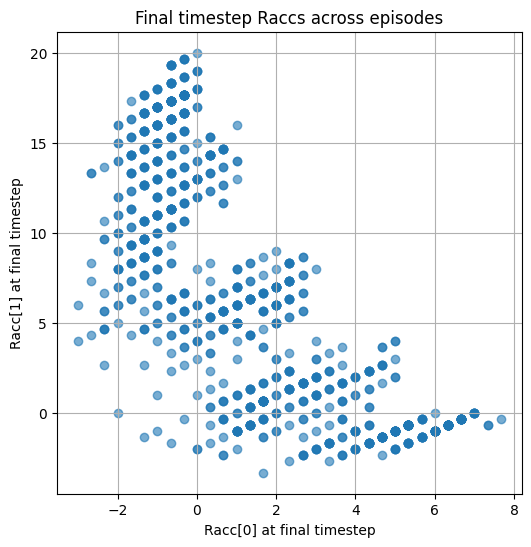

In [ ]:
import matplotlib.pyplot as plt

# 마지막 타임스텝의 Raccs (num_episodes, 2)
last_Raccs = episodes_data['Raccs'][:, -1, :]

# 산점도 플롯
plt.figure(figsize=(6,6))
plt.scatter(last_Raccs[:,0], last_Raccs[:,1], alpha=0.6)
plt.xlabel("Racc[0] at final timestep")
plt.ylabel("Racc[1] at final timestep")
plt.title("Final timestep Raccs across episodes")
plt.grid(True)
plt.show()


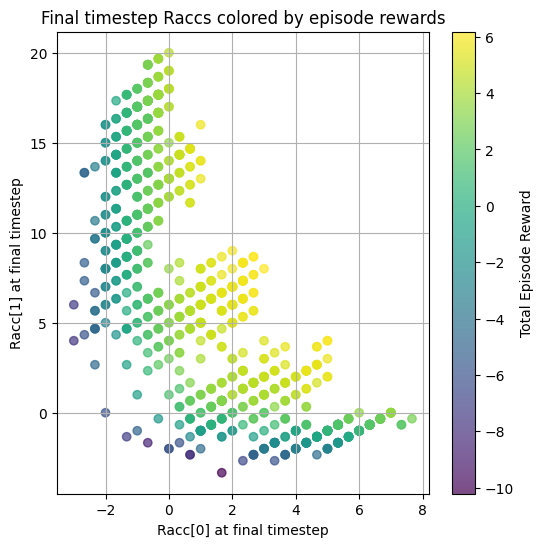

In [26]:
# 에피소드별 reward 합계
episode_rewards = episodes_data['rewards'].sum(axis=(1, 2))

plt.figure(figsize=(6,6))
sc = plt.scatter(
    last_Raccs[:,0], last_Raccs[:,1],
    c=episode_rewards, cmap='viridis', alpha=0.7
)
plt.xlabel("Racc[0] at final timestep")
plt.ylabel("Racc[1] at final timestep")
plt.title("Final timestep Raccs colored by episode rewards")
plt.colorbar(sc, label="Total Episode Reward")
plt.grid(True)
plt.show()


In [29]:
dataset['rewards'].min(), dataset['rewards'].max(), dataset['rewards'].mean(), dataset['rewards'].std()

(np.float32(-2.666667),
 np.float32(4.1666665),
 np.float32(0.020418549),
 np.float32(0.35863692))